In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing the U.S. Ad Impressions Dataset

In [3]:
# reads the U.S. advertisement impression dataset into the DataFrame "impressions" by iteratively concatenating files in groups of 25
impressions_path = '/content/drive/MyDrive/Kinesso/US EDA/US Data Sources/impression_dataframes/impressions_'
impressions = pd.read_pickle(impressions_path + "0.pkl")
for i in range(16):
  start = (25 * i) + 1
  stop = start + 25
  df_list = [pd.read_pickle(impressions_path + str(j) + ".pkl") for j in range(start, stop)]
  df_concat = pd.concat(df_list)
  impressions = pd.concat([impressions, df_concat])
  del df_list
  del df_concat

# drop any rows where the zip_code field contains a NaN
impressions.dropna(subset=['zip_code'], inplace=True)
impressions.reset_index(drop=True, inplace=True)

print(impressions.shape)
print(impressions.columns)

(19700256, 20)
Index(['impression_id', 'campaign_id', 'ad_group_id', 'audience_id',
       'supply_vendor', 'user_agent', 'region', 'city', 'device_type',
       'os_family', 'os', 'browser', 'media_cost', 'ttd_cost_in_usd',
       'partner_cost_in_usd', 'advertiser_cost_in_usd', 'zip_code',
       'device_make', 'device_model', 'carrier_id'],
      dtype='object')


In [4]:
impressions.head()

,impression_id,campaign_id,ad_group_id,audience_id,supply_vendor,user_agent,region,city,device_type,os_family,os,browser,media_cost,ttd_cost_in_usd,partner_cost_in_usd,advertiser_cost_in_usd,zip_code,device_make,device_model,carrier_id
0,feeb8dbc-212a-4fba-8f8e-322431e625bf,el02c6n,exazlvq,NaN,Telaria,Roku/DVP-9.30 (489.30E04194A),Minnesota,Minneapolis,6,1.0,101.0,1.0,0.01877,0.01877,0.019609,0.019609,55405.0,Roku,Digital Video player,NaN
1,b768bf1c-a433-44a1-9614-87f983118c94,pey7wjw,fcucjsu,1qh4zg7,freewheel,Roku/DVP-9.30 (509.30E04194A),California,Oceanside,6,1.0,101.0,1.0,0.03840,0.03840,0.042422,0.042422,92056.0,Roku,Digital Video player,NaN
2,742e59e3-9283-4f32-81eb-7ccfe01e13ae,pey7wjw,fcucjsu,1qh4zg7,freewheel,Roku/DVP-9.30 (519.30E04194A),Kentucky,Lancaster,6,1.0,101.0,1.0,0.03840,0.03840,0.042422,0.042422,40444.0,Roku,Digital Video player,NaN
3,9c298ba2-32e8-4a6e-adad-32f2f004bb95,pey7wjw,fcucjsu,1qh4zg7,freewheel,Roku/DVP-9.30 (919.30E04194A),California,Los Osos,6,1.0,101.0,1.0,0.03840,0.03840,0.042422,0.042422,93402.0,Roku,Digital Video player,NaN
4,66cea51b-267b-4a2e-96c0-fcd276e2521c,el02c6n,exazlvq,NaN,Telaria,Roku/DVP-9.30 (319.30E04194A),Pennsylvania,Philadelphia,6,1.0,101.0,1.0,0.01877,0.01877,0.019609,0.019609,19128.0,Roku,Digital Video player,NaN


## Importing the U.S. Demographic Distribution Dataset

In [5]:
# reads the U.S. demographic dataset into the DataFrame "demo" by iteratively concatenating files in groups of 20
demo_path = '/content/drive/MyDrive/Kinesso/US EDA/US Data Sources/zip_age_ethnicity_income_data/demo_data_'
demo = pd.DataFrame(columns = ['zip_code', 'age', 'ethnicity', 'income', 'count']) 
for i in range(19):
  start = (20 * i) + 1
  stop = start + 20
  demo_df_list = [pd.read_csv(demo_path + str(j) + '.csv').set_axis(['zip_code', 'age', 'ethnicity', 'income', 'count'], axis='columns') for j in range(start, stop)]
  demo_df_concat = pd.concat(demo_df_list)
  demo = pd.concat([demo, demo_df_concat])
  del demo_df_list
  del demo_df_concat

# drop rows with zip codes from Puerto Rico and Virgin Islands for the purposes of this analysis (examining states only)
demo.drop(demo[demo.zip_code < 1000].index, inplace=True)

print(demo.shape)
print(demo.columns)

(534000, 5)
Index(['zip_code', 'age', 'ethnicity', 'income', 'count'], dtype='object')


In [6]:
demo.head()

,zip_code,age,ethnicity,income,count
19217,1001,18-23,African American,"$125,000 - $149,999",1
19218,1001,18-23,African American,"$20,000 - $29,999",4
19219,1001,18-23,African American,"$30,000 - $39,999",1
19220,1001,18-23,African American,"$50,000 - $74,999",2
19221,1001,18-23,Asian,"$20,000 - $29,999",1


## Building the Table to Compare Zip Code Frequencies between the Demographic Dataset (Expectations) and Impressions Dataset (Observations)

In [7]:
# computes the frequency of each zip code in the impression data 
imp_by_zip = pd.DataFrame(impressions['zip_code'].value_counts()).reset_index().rename(columns={"zip_code": "impression_count", "index": "zip_code"})
imp_by_zip['zip_code'] = imp_by_zip['zip_code'].astype(int)
imp_by_zip.set_index('zip_code', inplace=True)
imp_by_zip['observed_zip_freq'] = impressions['zip_code'].value_counts(normalize=True)
imp_by_zip.head()

,impression_count,observed_zip_freq
zip_code,,
36117,18317,0.000930
20149,17493,0.000888
65203,15266,0.000775
37042,13578,0.000689
63033,13285,0.000674


In [8]:
# after grouping the demographic data by zip code, computes the frequency of each zip code by the number of households 
demo_pop = demo['count'].sum()
demo_pop_by_zip = demo.groupby(['zip_code']).agg({'count': 'sum'})
demo_pop_by_zip.rename(columns={"count": "household_count"}, inplace=True)
demo_pop_by_zip['household_count'] = demo_pop_by_zip['household_count'].astype(float)
demo_pop_by_zip['expected_zip_freq'] = demo_pop_by_zip['household_count'] / demo_pop
demo_pop_by_zip.head()

,household_count,expected_zip_freq
zip_code,,
1001,14822.0,8.815180e-04
1002,22030.0,1.310204e-03
1003,9.0,5.352626e-07
1004,462.0,2.747681e-05
1005,3954.0,2.351587e-04


In [9]:
# joins the two dataframes above on zip code (outer join because there are zip codes in each dataset that do not exist in the other dataset) 
zip_joined = pd.concat([imp_by_zip, demo_pop_by_zip], axis=1, join='outer', sort=False)
# replace NaNs with 0 to make subtraction calculation in next cell
zip_joined.fillna(0, inplace=True)
zip_joined.head()

,impression_count,observed_zip_freq,household_count,expected_zip_freq
zip_code,,,,
1001,731.0,3.710612e-05,14822.0,8.815180e-04
1002,1365.0,6.928844e-05,22030.0,1.310204e-03
1003,8.0,4.060861e-07,9.0,5.352626e-07
1004,16.0,8.121722e-07,462.0,2.747681e-05
1005,15.0,7.614114e-07,3954.0,2.351587e-04


In [10]:
# calculates differences between "observed" zip code frequencies from the impression data and "expected" zip code frequencies from the demographic data
zip_joined['freq_difference'] = zip_joined['observed_zip_freq'] - zip_joined['expected_zip_freq']
zip_joined = zip_joined[['impression_count', 'household_count',	'observed_zip_freq',	'expected_zip_freq', 'freq_difference']]
zip_joined.sort_values(by='freq_difference', inplace=True)
zip_joined.head(20)

,impression_count,household_count,observed_zip_freq,expected_zip_freq,freq_difference
zip_code,,,,,
11375,4344.0,60730.0,0.000221,0.003612,-0.003391
11377,4199.0,59135.0,0.000213,0.003517,-0.003304
23464,9971.0,60145.0,0.000506,0.003577,-0.003071
60617,7754.0,58217.0,0.000394,0.003462,-0.003069
60618,8573.0,57487.0,0.000435,0.003419,-0.002984
77083,3512.0,53078.0,0.000178,0.003157,-0.002978
92114,2492.0,50140.0,0.000126,0.002982,-0.002856
11219,572.0,48029.0,0.000029,0.002856,-0.002827
19720,5350.0,51805.0,0.000272,0.003081,-0.002809


## Sampling the Demographic Dataset According to the Observed Frequency of a Given Zip Code in the Impression Dataset to Approximate the Demographics of the Reached Audience at this Zip Code

In [11]:
# given a zip code and DataFrame comparing zip code frequencies, produces a simulation of the demographic features of the audience behind the impressions \ 
# (with those features being age, ethnicity, and income) 
def sample_zip_demographics(zip_code, zip_joined):
  demo_zip = demo[demo['zip_code'] == zip_code].copy()
  demo_zip_total = demo_zip['count'].sum()
  impression_counts = demo_zip['count'] * (zip_joined[zip_joined.index == zip_code]['observed_zip_freq'].values[0] / zip_joined[zip_joined.index == zip_code]['expected_zip_freq'].values[0])
  impression_counts_total = impression_counts.sum() 
  # gets simulated frequency of each (age, ethnicity, income) triple after reweighting by the number of impressions at this zip code instead of by the number of households
  impression_freqs = impression_counts / impression_counts_total
  
  demo_zip.reset_index(drop=True, inplace=True)
  demo_zip.reset_index(inplace=True)
  
  # adds noise to simulated frequencies to introduce more randomness to the sampling
  indices = [i for i in demo_zip['index']]
  freqs = np.array([f for f in impression_freqs])
  searching = True
  while searching:
    freqs_plus_noise = freqs + np.random.normal(0, impression_freqs.min() * 20, size=len(freqs))
    freqs_plus_noise = np.clip(freqs_plus_noise, 0, 1)
    total_freq = sum(freqs_plus_noise)
    if total_freq > 0:
      freqs_plus_noise = freqs_plus_noise / total_freq
      searching = False

  # samples using the generated frequencies and outputs new DataFrame
  num_samples = round(impression_counts_total)
  samples = np.random.choice(a=indices, size=num_samples, p=freqs_plus_noise)
  impression_sample = np.bincount(samples, minlength=len(indices))
  demo_zip['impression_sample'] = impression_sample
  demo_zip['expected_freq'] = demo_zip['count'] / demo_zip_total
  demo_zip['sample_freq'] = demo_zip['impression_sample'] / num_samples
  demo_zip.drop(columns=['index'], inplace=True)
  return demo_zip

In [12]:
# example output of sample_zip_demographics
demo_11375 = sample_zip_demographics(11375, zip_joined)
demo_11375

,zip_code,age,ethnicity,income,count,impression_sample,expected_freq,sample_freq
0,11375,18-23,African American,"$15,000 - $19,999",1,0,1.64663e-05,0.00000
1,11375,18-23,African American,"$20,000 - $29,999",2,0,3.29327e-05,0.00000
2,11375,18-23,African American,"$30,000 - $39,999",2,0,3.29327e-05,0.00000
3,11375,18-23,African American,"$40,000 - $49,999",1,0,1.64663e-05,0.00000
4,11375,18-23,African American,"$50,000 - $74,999",3,0,4.9399e-05,0.00000
...,...,...,...,...,...,...,...,...
532,11375,not_reported,not_reported,"$100,000 - $124,999",517,32,0.00851309,0.00863
533,11375,not_reported,not_reported,"$40,000 - $49,999",4,0,6.58653e-05,0.00000
534,11375,not_reported,not_reported,"$50,000 - $74,999",3,0,4.9399e-05,0.00000
535,11375,not_reported,not_reported,"$75,000 - $99,999",12,0,0.000197596,0.00000


In [13]:
# filter output of sample_zip_demographics by feature, in this case by age
age_grouped = demo_11375.groupby(['zip_code', 'age']).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
age_grouped

count  impression_sample  expected_freq  sample_freq
zip_code age                                                               
11375    18-23          1227                 86       0.020204     0.023193
         24-29          2514                159       0.041396     0.042880
         30-35          4139                228       0.068154     0.061489
         36-41          5027                297       0.082776     0.080097
         42-47          5497                351       0.090515     0.094660
         48-53          5757                366       0.094797     0.098706
         54-59          5776                324       0.095110     0.087379
         60-65          5726                342       0.094286     0.092233
         66 and above  17060               1038       0.280916     0.279935
         not_reported   8007                517       0.131846     0.139428

In [14]:
# filter output of sample_zip_demographics by feature, in this case by ethnicity
ethnicity_grouped = demo_11375.groupby(['zip_code', 'ethnicity']).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
ethnicity_grouped

count  impression_sample  expected_freq  sample_freq
zip_code ethnicity                                                             
11375    African American   1188                 84       0.019562     0.022654
         Asian             13981                847       0.230216     0.228425
         Hispanic           7293                505       0.120089     0.136192
         White             37701               2240       0.620797     0.604099
         not_reported        567                 32       0.009336     0.008630

In [15]:
# filter output of sample_zip_demographics by feature, in this case by income
income_grouped = demo_11375.groupby(['zip_code', 'income']).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
income_grouped

count  ...  sample_freq
zip_code income                      ...             
11375    $1,000 - $14,999      1166  ...     0.025890
         $100,000 - $124,999   7609  ...     0.121090
         $125,000 - $149,999   2150  ...     0.034790
         $15,000 - $19,999     1424  ...     0.020496
         $150,000 - $174,999   1035  ...     0.023732
         $175,000 - $199,999    756  ...     0.015642
         $20,000 - $29,999     3516  ...     0.053937
         $200,000 - $249,999    878  ...     0.016721
         $250,000 or greater   1552  ...     0.023193
         $30,000 - $39,999     3321  ...     0.046117
         $40,000 - $49,999     3676  ...     0.067422
         $50,000 - $74,999    16316  ...     0.271036
         $75,000 - $99,999    11830  ...     0.185275
         not_reported          5501  ...     0.094660

[14 rows x 4 columns]

## Measuring Bias Against a Given Zip Code and Feature

In [16]:
import scipy
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon
from scipy.stats import chisquare

# measures bias of a given feature in a zip code by comparing expected and observed distributions.
# has three options for metrics: Kullback-Leibler (KL) Divergence, Jensen-Shannon (JS) Divergence, and Chi-Squared Test.
def calculate_bias(p, q, zip_code, bias_metric):
  total_freq_o = zip_joined[zip_joined.index == zip_code]['observed_zip_freq'].values[0]
  total_freq_e = zip_joined[zip_joined.index == zip_code]['expected_zip_freq'].values[0]
  sign = np.sign(zip_joined[zip_joined.index == zip_code]['freq_difference'].values)[0]
  
  # for the KL and JS Divergences, result is weighted by the ratio of observed to expected zip frequency and the sign \ 
  # of the difference of these values, so underrepresented (zip code, feature) pairs have negative bias scores and \ 
  # overrepresented (zip code, feature) pairs have positive bias scores 
  if bias_metric == 0 or bias_metric == 'kl': # Kullback-Leibler Divergence 
    return sum(rel_entr(p, q)) / (total_freq_o / total_freq_e) * sign
  elif bias_metric == 1 or bias_metric == 'js': # Jensen-Shannon Divergence
    return jensenshannon(p, q) / (total_freq_o / total_freq_e) * sign
  elif bias_metric == 2 or bias_metric == 'chi2': # Chi-Squared Test
    return chisquare(p, q) 

In [41]:
# calculates bias scores of zip code 11375 on each of the three demographic features using each of the three metrics 
age_grouped.reset_index(inplace=True)
print('Comparing Bias of Age Distributions for Zip Code: 11375')
print('Kullback-Leibler Divergence: ' + str(calculate_bias(age_grouped['expected_freq'], age_grouped['sample_freq'], 11375, 0)))
print('Jensen-Shannon Divergence: ' + str(calculate_bias(age_grouped['expected_freq'], age_grouped['sample_freq'], 11375, 1)))
print('Chi-Squared Test: ' + str(calculate_bias(age_grouped['count'], age_grouped['impression_sample'], 11375, 2)))
print()

ethnicity_grouped.reset_index(inplace=True)
print('Comparing Bias of Ethnicity Distributions for Zip Code: 11375')
print('Kullback-Leibler Divergence: ' + str(calculate_bias(ethnicity_grouped['expected_freq'], ethnicity_grouped['sample_freq'], 11375, 0)))
print('Jensen-Shannon Divergence: ' + str(calculate_bias(ethnicity_grouped['expected_freq'], ethnicity_grouped['sample_freq'], 11375, 1)))
print('Chi-Squared Test: ' + str(calculate_bias(ethnicity_grouped['count'], ethnicity_grouped['impression_sample'], 11375, 2)))
print()

income_grouped.reset_index(inplace=True)
print('Comparing Bias of Income Distributions for Zip Code: 11375')
print('Kullback-Leibler Divergence: ' + str(calculate_bias(income_grouped['expected_freq'], income_grouped['sample_freq'], 11375, 0)))
print('Jensen-Shannon Divergence: ' + str(calculate_bias(income_grouped['expected_freq'], income_grouped['sample_freq'], 11375, 1)))
print('Chi-Squared Test: ' + str(calculate_bias(income_grouped['count'], income_grouped['impression_sample'], 11375, 2)))

Comparing Bias of Age Distributions for Zip Code: 11375
Kullback-Leibler Divergence: -0.022242230167981714
Jensen-Shannon Divergence: -0.3014402763185196
Chi-Squared Test: Power_divergenceResult(statistic=879605.9160661483, pvalue=0.0)

Comparing Bias of Ethnicity Distributions for Zip Code: 11375
Kullback-Leibler Divergence: -0.02419342188857421
Jensen-Shannon Divergence: -0.3173548047166287
Chi-Squared Test: Power_divergenceResult(statistic=879734.1299637553, pvalue=0.0)

Comparing Bias of Income Distributions for Zip Code: 11375
Kullback-Leibler Divergence: -0.07375419460524969
Jensen-Shannon Divergence: -0.5552630716810323
Chi-Squared Test: Power_divergenceResult(statistic=885511.5862737196, pvalue=0.0)


Demonstrated by the outputs above, the bias metrics increase in their sensitivity to differences between two distributions as we go from the Kullback-Leibler Divergence to the Jensen-Shannon Divergence to the Chi-Square Test.

## Diversifying the Reached Audience of an Ad Campaign

In [18]:
# given a feature and bias metric, measures the amount of money and number of impressions needed to reach a lower bias threshold for a zip code
def diversification_plan(zip_code, feature, bias_metric, maintain_budget, max_bias, step_size):
  zip_joined_copy = zip_joined.copy().reset_index()
  demo_zip = sample_zip_demographics(zip_code, zip_joined_copy.set_index('zip_code'))
  grouped = demo_zip.groupby(['zip_code', feature]).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
  curr_bias = calculate_bias(grouped['expected_freq'], grouped['sample_freq'], zip_code, bias_metric)
  total_impressions = zip_joined_copy['impression_count'].sum()

  total_cost = impressions[impressions['zip_code'] == zip_code]['advertiser_cost_in_usd'].sum()
  changes = dict()
  changes[zip_code] = {'num_impressions': [zip_joined_copy[zip_joined_copy['zip_code'] == zip_code].loc[:, 'impression_count'].values[0]],
                       'bias': [curr_bias],
                       'total_cost': [total_cost]}

  # unlimited budget option: continually increases impressions by step_size and cost until the bias has decreased past the threshold
  if maintain_budget == False:
    cost_per_ad = impressions[impressions['zip_code'] == zip_code]['advertiser_cost_in_usd'].mean() + (np.random.random_sample() / np.random.randint(100, 1001))
    while curr_bias < max_bias:
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'impression_count'] += step_size
      total_impressions += step_size
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'observed_zip_freq'] = zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'impression_count'] / total_impressions
      demo_zip = sample_zip_demographics(zip_code, zip_joined_copy.set_index('zip_code'))
      grouped = demo_zip.groupby(['zip_code', feature]).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
      curr_bias = calculate_bias(grouped['expected_freq'], grouped['sample_freq'], zip_code, bias_metric)
      total_cost += cost_per_ad * step_size
      changes[zip_code]['num_impressions'].append(zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'impression_count'].values[0])
      changes[zip_code]['bias'].append(curr_bias)
      changes[zip_code]['total_cost'].append(total_cost)
  # limited budget option: using the money already in the "system," iteratively diverts costs and impressions (step_size at a time) away from the overrepresented \
  # zip codes and directs them toward the underrepresented zip code passed in until the bias against this zip code has decreased past the threshold
  else:
    count = 0
    seen = set()
    overrep_zips = zip_joined_copy[(zip_joined_copy['freq_difference'] > 0) & (zip_joined_copy['household_count'] > 0)].sort_values(by='freq_difference', ascending=False)
    cost_per_ad = impressions[impressions['zip_code'] == zip_code]['advertiser_cost_in_usd'].mean()
    while curr_bias < max_bias:
      curr_donor = overrep_zips.iloc[count]
      donor_zip = int(curr_donor['zip_code'])
      
      # maintain set of overrepresented zip codes to take resources from and track changes in bias and number of impressions
      if donor_zip not in seen:
        changes[donor_zip] = dict()
        changes[donor_zip]['num_impressions'] = [zip_joined_copy.loc[zip_joined_copy['zip_code'] == donor_zip, 'impression_count'].values[0]]
        start_donor_demo_zip = sample_zip_demographics(donor_zip, zip_joined_copy.set_index('zip_code'))
        start_donor_grouped = start_donor_demo_zip.groupby(['zip_code', feature]).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
        changes[donor_zip]['bias'] = [calculate_bias(start_donor_grouped['expected_freq'], start_donor_grouped['sample_freq'], donor_zip, bias_metric)]
        changes[donor_zip]['total_cost'] = [impressions[impressions['zip_code'] == donor_zip]['advertiser_cost_in_usd'].sum()]
        seen.add(donor_zip)

      # decreases the total cost for impressions in the overrepresented zip code by the same amount that we increase the total cost for impressions in the underrepresented \
      # zip code 
      donor_cost_per_ad = impressions[impressions['zip_code'] == donor_zip]['advertiser_cost_in_usd'].mean()
      changes[donor_zip]['total_cost'].append(changes[donor_zip]['total_cost'][-1] - (step_size * donor_cost_per_ad))
      changes[zip_code]['total_cost'].append(changes[zip_code]['total_cost'][-1] + (step_size * donor_cost_per_ad))

      # updates frequency comparison table after increasing the prevalence of the underrepresented zip code to calculate how its bias score has changed
      num_impressions = round(step_size * donor_cost_per_ad / cost_per_ad)
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'impression_count'] += num_impressions
      total_impressions = total_impressions - step_size + num_impressions
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'observed_zip_freq'] = zip_joined_copy.loc[zip_joined_copy['zip_code'] == zip_code, 'impression_count'] / total_impressions
      demo_zip = sample_zip_demographics(zip_code, zip_joined_copy.set_index('zip_code'))
      grouped = demo_zip.groupby(['zip_code', feature]).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
      curr_bias = calculate_bias(grouped['expected_freq'], grouped['sample_freq'], zip_code, bias_metric)
      # tracks changes to number of impressions and bias score for the underrepresented zip code 
      changes[zip_code]['num_impressions'].append(changes[zip_code]['num_impressions'][-1] + num_impressions)
      changes[zip_code]['bias'].append(curr_bias)

      # updates frequency comparison table after decreasing the prevalence of the "donating" overrepresented zip code to calculate how its bias score has changed
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == donor_zip, 'impression_count'] -= step_size
      zip_joined_copy.loc[zip_joined_copy['zip_code'] == donor_zip, 'observed_zip_freq'] = zip_joined_copy.loc[zip_joined_copy['zip_code'] == donor_zip, 'impression_count'] / total_impressions
      donor_demo_zip = sample_zip_demographics(donor_zip, zip_joined_copy.set_index('zip_code'))
      donor_grouped = donor_demo_zip.groupby(['zip_code', feature]).agg({'count': 'sum', 'impression_sample': 'sum', 'expected_freq': 'sum', 'sample_freq': 'sum'})
      # tracks changes to number of impressions and bias score for the overrepresented zip code that is "donating its resources"
      changes[donor_zip]['num_impressions'].append(changes[donor_zip]['num_impressions'][-1] - step_size)
      changes[donor_zip]['bias'].append(calculate_bias(donor_grouped['expected_freq'], donor_grouped['sample_freq'], donor_zip, bias_metric))

      count = (count + 1) % len(overrep_zips) 
  return changes

In [ ]:
div_unlim = diversification_plan(11375, 'income', 'js', False, -0.12, 1000)

In [25]:
# printing only the first 5 and last 5 bias scores for purposes of output brevity
print('bias:', div_unlim[11375]['bias'][:5], '...', div_unlim[11375]['bias'][-5:])
# printing only the first 5 and last 5 total cost calculations for purposes of output brevity
print('total_cost:', div_unlim[11375]['total_cost'][:5], '...', div_unlim[11375]['total_cost'][-5:])

bias: [-0.5464736666198173, -0.38707143808858774, -0.2943019373515795, -0.19614126557837006, -0.3605622159179953] ... [-0.3282956969727133, -0.23129858241858986, -0.3063671697470281, -0.28737983083582197, -0.08842813761075984]
total_cost: [117.91488095709204, 146.5559579124742, 175.1970348678564, 203.83811182323856, 232.47918877862074] ... [13235.528126522151, 13264.169203477533, 13292.810280432916, 13321.451357388298, 13350.09243434368]


In [26]:
div_lim = diversification_plan(11375, 'income', 'js', True, -0.25, 100)

In [27]:
div_lim.keys()

dict_keys([11375, 65109, 38614, 62025, 35801, 57105, 35055, 31204, 13502, 27909, 14616, 32607, 61081, 29625, 75092, 13207])

In [30]:
# printing only the first 5 and last 5 bias scores for the underrepresented zip code (11375) for purposes of output brevity
print('bias:', div_lim[11375]['bias'][:5], '...', div_lim[11375]['bias'][-5:])
# printing the first 5 and last 5 total cost calculations for the underrepresented zip code (11375) for purposes of output brevity
print('total_cost:', div_lim[11375]['total_cost'][:5], '...', div_lim[11375]['total_cost'][-5:])

bias: [-0.5390690597926803, -0.5060057925648727, -0.3105980729752306, -0.4344930086897793, -0.3967205963278547] ... [-0.42277873081586914, -0.4097612303502184, -0.47907136038281306, -0.49288524491084285, -0.23558090319720973]
total_cost: [117.91488095709204, 120.4632240645734, 123.42821876487616, 125.99610669649142, 128.7476938391247] ... [147.58609574713316, 150.2160802547803, 152.89590750080535, 155.79348672821646, 158.45754424054238]


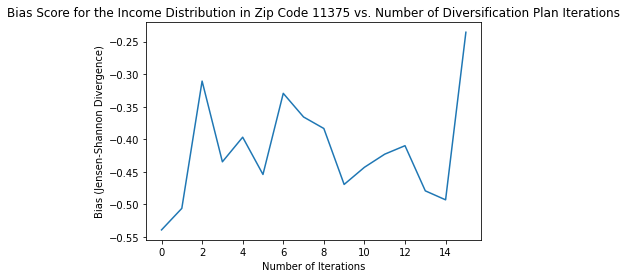

In [40]:
plt.plot(div_lim[11375]['bias'])
plt.title('Bias Score for the Income Distribution in Zip Code 11375 vs. Number of Diversification Plan Iterations')
plt.ylabel('Bias (Jensen-Shannon Divergence)')
plt.xlabel('Number of Iterations')
plt.show()

As we can see in the plot above, the bias does not decrease toward its threshold at a constant rate in accordance with the number of iterations that the diversification algorithm has run. This is due to the fact that we reweight our frequency table at each iteration and thus have to resample from the demographic data with the function `sample_zip_demographics`, which utilizes randomness to create a more realistic sample. 

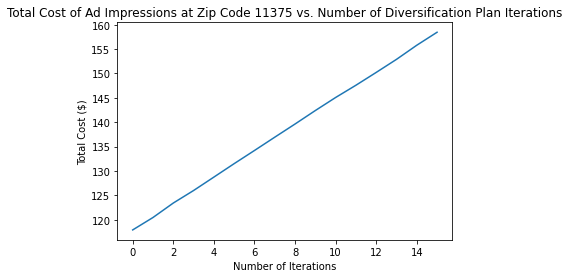

In [38]:
plt.plot(div_lim[11375]['total_cost'])
plt.title('Total Cost of Ad Impressions at Zip Code 11375 vs. Number of Diversification Plan Iterations')
plt.ylabel('Total Cost ($)')
plt.xlabel('Number of Iterations')
plt.show()

As we can see in the plot above, the total cost steadily increases as the diversification algorithn runs and allocates more impressions to the underrepresented zip code at each iteration.

In [32]:
# printing the bias scores for an overrepresented zip code (65109)
print('bias:', div_lim[65109]['bias'])
# printing the total cost calculations for an overrepresented zip code (65109) 
print('total_cost:', div_lim[65109]['total_cost'])

bias: [0.017400152750348015, 0.017713588585868616]
total_cost: [260.82291705073123, 258.2745739432499]


As we can see with the output in the cell above, only two iterations of the diversification algorithm involved diverting resources from the zip code 65109, and that is because it takes resources from multiple overrepresented zip codes.